# <center> Практика. Статистические тесты в контексте EDA

### **1. Постановка задачи:**

**ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА**

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа необходимо исследовать данные и выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

***ДАННЫЕ HR-АГЕНТСТВА:***

Наименование столбца:  | Описание столбца:
------- | --------
***work_year***   | Год, в котором была выплачена зарплата.
***experience_level***   | Опыт работы на этой должности в течение года со следующими возможными значениями: <br> - ***EN*** — Entry-level/Junior; <br>- ***MI*** — Mid-level/Intermediate; <br> - ***SE*** — Senior-level/Expert; <br>- ***EX*** — Executive-level/Director.
***employment_type***   | Тип трудоустройства для этой роли: <br> - ***PT*** — неполный рабочий день; <br> - ***FT*** — полный рабочий день; <br> - ***CT*** — контракт; <br> - ***FL*** — фриланс.
***job_title***   | Роль, в которой соискатель работал в течение года.
***salary***   | Общая выплаченная валовая сумма заработной платы.
***salary_currency***   | Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
***salary_in_usd***   | Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
***employee_residence***   | Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
***remote_ratio***   | Общий объём работы, выполняемой удалённо. <br> Возможные значения: <br> ***0*** — удалённой работы нет (менее 20 %); <br> ***50*** — частично удалённая работа; <br> ***100*** — полностью удалённая работа (более 80 %).
***company_location***   | Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
***company_size***   | Среднее количество людей, работавших в компании в течение года: <br>  - ***S*** - менее 50 сотрудников (небольшая компания); <br> - ***M*** - от 50 до 250 сотрудников (средняя компания); <br> - ***L*** - более 250 сотрудников (крупная компания).

## **1. Загрузка и обработка данных:**

In [1]:
# Загружаем необходимые библиотеки:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Делаем визуальную настройку графиков:
sns.set_theme("notebook") 
sns.set_palette("Set2")

In [2]:
# Загружаем датасет:
data = pd.read_csv('ds_salaries.csv')
data.head(5)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# Задаём уровень значимости:
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


1.1. Посмотрим сводную информацию методом info():

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


**Вывод:** в датасете 607 записей (без пропущенных значений).

1.2. Проверим данные на наличие дубликатов и удалим найденные дубликаты:

In [5]:
# Проверяем наличие дубликатов:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


**Вывод:** представленные данные не содержат полных дубликатов.


1.3. Определим в данных неинформативные признаки, которые не будут участвовать в исследовании:

In [6]:
# Удаляем столбцы "salary" и "salary_currency" из DataFrame:
data = data.drop(columns=['salary', 'salary_currency'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary_in_usd       607 non-null    int64 
 6   employee_residence  607 non-null    object
 7   remote_ratio        607 non-null    int64 
 8   company_location    607 non-null    object
 9   company_size        607 non-null    object
dtypes: int64(4), object(6)
memory usage: 47.5+ KB


**Вывод:** удалим из данных признаки:

- **salary** аналогичный более универсальному признаку **salary_in_usd**;
- **salary_currency** так как мы будем оперировать зарплатой уже переведенной в доллары США.

1.4. Классифицируем все признаки на числовые и категориальные:

Классификация признаков датасета: | Признак:
------- | --------
***Категориальные признаки:*** |experience_level; <br> employment_type; <br> job_title; <br> employee_residence; <br> remote_ratio; <br> company_location; <br> company_location
***Числовые признаки:*** |work_year; <br> salary_in_usd

1.5. Определим основные статистические характеристики для каждого из признаков:

In [7]:
data.describe(include='all')

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,607.000000,607.000000,607,607,607,607.000000,607,607.00000,607,607
unique,NaN,NaN,4,4,50,NaN,57,NaN,50,3
top,NaN,NaN,SE,FT,Data Scientist,NaN,US,NaN,US,M
freq,NaN,NaN,280,588,143,NaN,332,NaN,355,326
mean,303.000000,2021.405272,NaN,NaN,NaN,112297.869852,NaN,70.92257,NaN,NaN
std,175.370085,0.692133,NaN,NaN,NaN,70957.259411,NaN,40.70913,NaN,NaN
min,0.000000,2020.000000,NaN,NaN,NaN,2859.000000,NaN,0.00000,NaN,NaN
25%,151.500000,2021.000000,NaN,NaN,NaN,62726.000000,NaN,50.00000,NaN,NaN
50%,303.000000,2022.000000,NaN,NaN,NaN,101570.000000,NaN,100.00000,NaN,NaN
75%,454.500000,2022.000000,NaN,NaN,NaN,150000.000000,NaN,100.00000,NaN,NaN


**Вывод:** с помощью метода describe() определили основные статистические характеристики для каждого из признаков.

## **2. Разведывательный анализ данных:**

2.1. Визуальный анализ данных:

Распределение заработной платы:

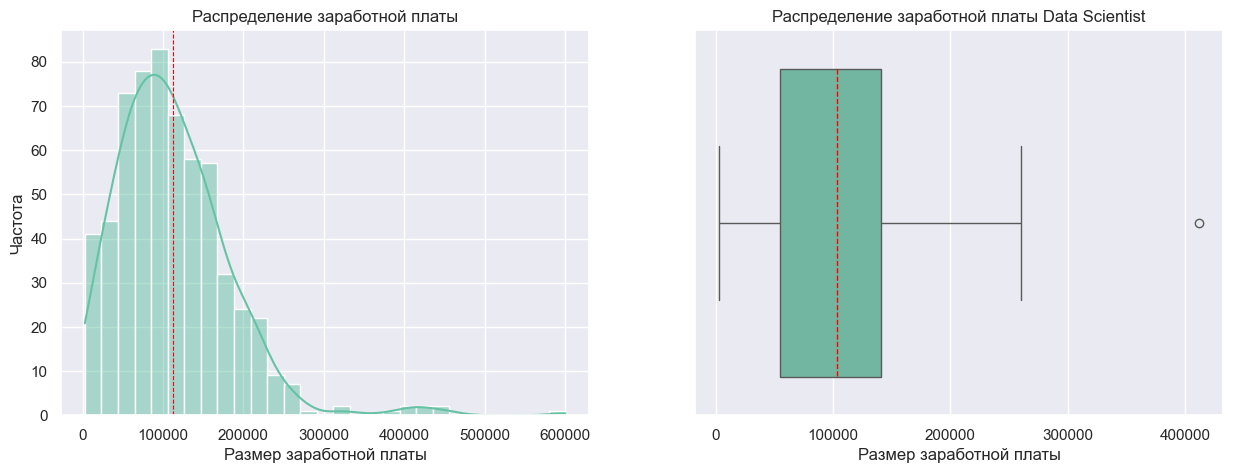

In [66]:
# Построим диаграмму:

fig, axes = plt.subplots(1, 2, figsize = (15, 5))

sns.histplot(data['salary_in_usd'], kde = True, ax = axes[0])
# Присваиваем заголовки осей координат:
axes[0].set(xlabel = 'Размер заработной платы', ylabel = 'Частота')
# Заголовок графика:
axes[0].set_title('Распределение заработной платы')
# Вертикальная линия:
axes[0].axvline(data['salary_in_usd'].mean(),
                color = 'red', linestyle = '--', linewidth = 0.8)

# Отфильтруем данные для Data Scientist:
filtered_data = data[data['job_title'] == 'Data Scientist']
sns.boxplot(filtered_data['salary_in_usd'], ax=axes[1],
            # Горизонтальная ориентация диаграммы:
            orient='h',
            # Медиана:
            medianprops = {"color": "red", "linestyle": '--'})
# Присваиваем заголовки осей координат:
axes[1].set(xlabel = 'Размер заработной платы')
# Заголовок графика:
axes[1].set_title('Распределение заработной платы Data Scientist')
# Выводим результат на экран:
plt.show()

In [20]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер заработной платы']
data_agg

,Размер заработной платы
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


**Вывод:** распределение заработной платы отлично от нормального, имеются выбросы.

Распределение заработной платы по годам:

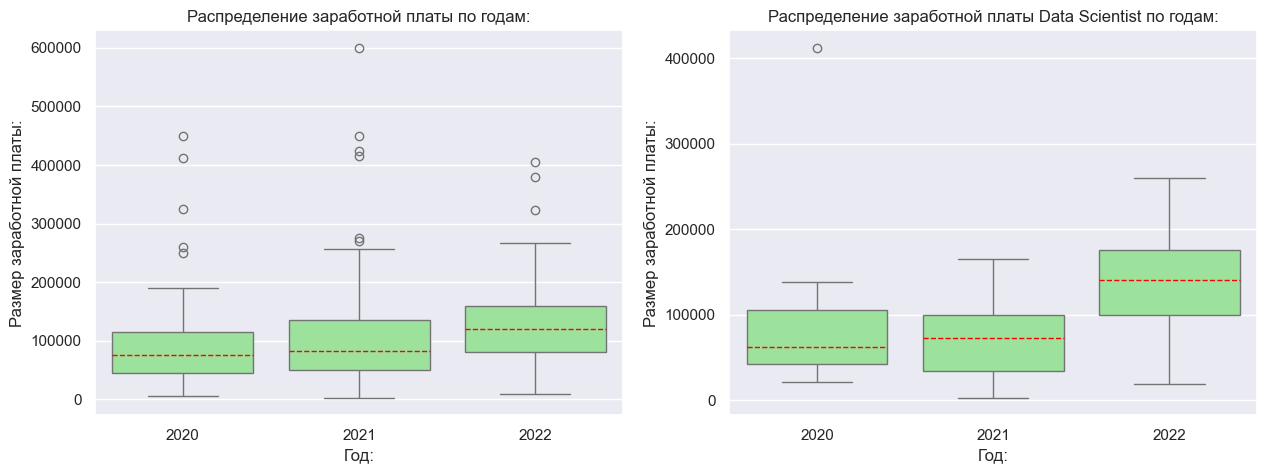

In [67]:
# Построим диаграмму:

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.boxplot(data,
            # Признак, который будет отложен по оси абсцисс:            
            # Год, в котором была выплачена заработная плата
            x = 'work_year',
            # Признак, который будет отложен по оси ординат:
            # Заработная плата
            y = 'salary_in_usd',
            ax = axes[0],
            # Вертикальная ориентация диаграммы:
            orient = 'v',
            # Цвет графика:
            color = 'lightgreen',
            # Медиана:
            medianprops = {"color": "red", "linestyle": '--'})
# Присваиваем заголовки осей координат:
axes[0].set(xlabel = 'Год:')
axes[0].set(ylabel = 'Размер заработной платы:')
# Заголовок графика:
axes[0].set_title('Распределение заработной платы по годам:')

# Отфильтруем данные для Data Scientist:
filtered_data = data[data['job_title'] == 'Data Scientist']
sns.boxplot(filtered_data,
            # Признак, который будет отложен по оси абсцисс:            
            # Год, в котором была выплачена заработная плата
            x = 'work_year',
            # Признак, который будет отложен по оси ординат:
            # Заработная плата
            y = 'salary_in_usd',
            ax=axes[1],
            # Вертикальная ориентация диаграммы:
            orient='v',
            # Цвет графика:
            color = 'lightgreen',
            # Медиана:
            medianprops = {"color": "red", "linestyle": '--'})
# Присваиваем заголовки осей координат:
axes[1].set(xlabel = 'Год:')
axes[1].set(ylabel = 'Размер заработной платы:')
# Заголовок графика:
axes[1].set_title('Распределение заработной платы Data Scientist по годам:')
# Выводим результат на экран:
plt.show()

In [68]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение заработной платы по годам:')
data_agg

Распределение заработной платы по годам:


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


На первый взгляд распределения страховых выплат для разных полов различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

### Страховые выплаты в зависимости от того, курит ли клиент.

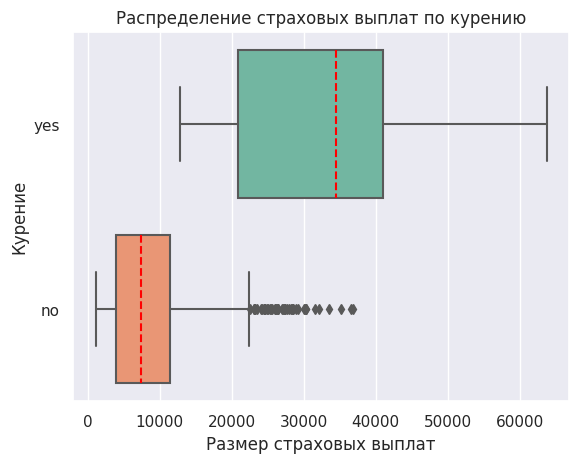

In [ ]:
ax = sns.boxplot(data, x='charges', y='smoker', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер страховых выплат', ylabel='Курение')
plt.title('Распределение страховых выплат по курению')
plt.show()

In [ ]:
data_agg = data.groupby('smoker')['charges'].describe().round(2)
print('Страховые выплаты в зависимости от курения')
data_agg

Страховые выплаты в зависимости от курения


,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1063.0,8440.66,5992.97,1121.87,3988.88,7345.73,11363.02,36910.61
yes,274.0,32050.23,11541.55,12829.46,20826.24,34456.35,41019.21,63770.43


Распределения страховых выплат различны в зависимости от того, курит ли клиент. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Страховые выплаты в зависимости от региона

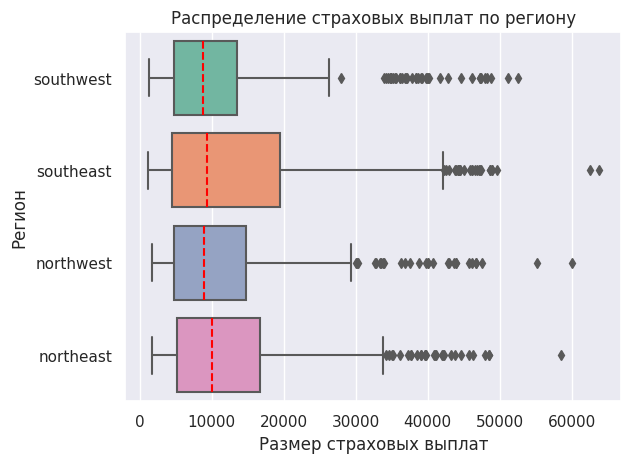

In [ ]:
ax = sns.boxplot(data, x='charges', y='region', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер страховых выплат', ylabel='Регион')
plt.title('Распределение страховых выплат по региону')
plt.show()

In [ ]:
data_agg = data.groupby('region')['charges'].describe().round(2)
print('Страховые выплаты в зависимости от региона')
data_agg

Страховые выплаты в зависимости от региона


,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
northeast,324.0,13406.38,11255.80,1694.80,5194.32,10057.65,16687.36,58571.07
northwest,324.0,12450.84,11073.13,1621.34,4733.64,8976.98,14788.75,60021.40
southeast,364.0,14735.41,13971.10,1121.87,4440.89,9294.13,19526.29,63770.43
southwest,325.0,12346.94,11557.18,1241.56,4751.07,8798.59,13462.52,52590.83


Распределения страховых выплат различны для разных регионов. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Соотношение курящих среди мужчин и женщин

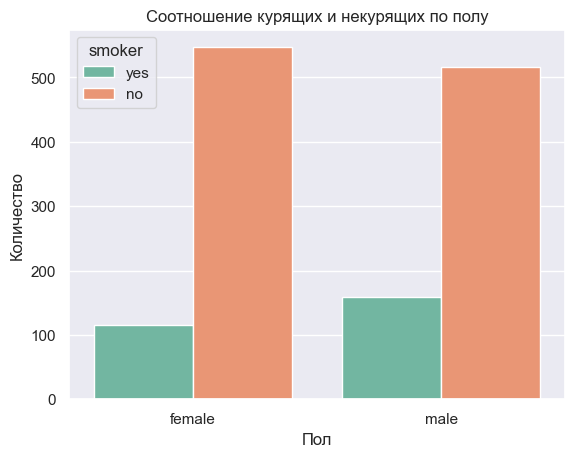

In [ ]:
ax = sns.countplot(data=data, x=data['sex'], hue='smoker')
ax.set(xlabel='Пол', ylabel='Количество')
plt.title('Соотношение курящих и некурящих по полу')
plt.show()

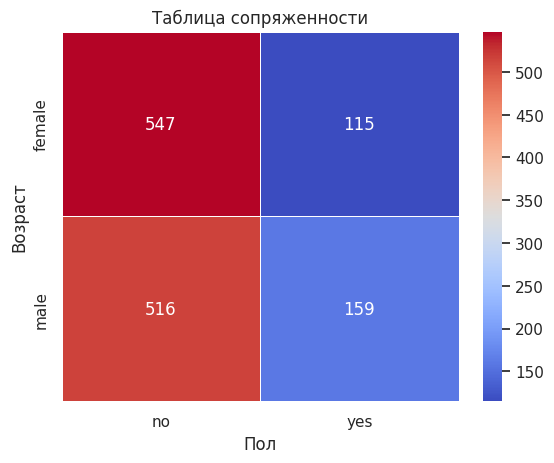

In [ ]:
cross_tab = pd.crosstab(index=data['sex'], columns=data['smoker'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Пол', ylabel='Возраст')
plt.title('Таблица сопряженности')
plt.show()

Согласно данным, среди курящих мужчин больше, чем женщин. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных



In [ ]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер страховых выплат клиентов-мужчин ($μ_1$) статистически меньше либо равен размеру страховых выплат клиентов-женщин ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер страховых выплат клиентов-мужчин ($μ_1$) статистически больше, чем размер страховых выплат клиентов-женщин ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [ ]:
# значения страховых выплат
charges_male = data.loc[data['sex']=='male', 'charges']
charges_female = data.loc[data['sex']=='female', 'charges']

# проводим тест Шапиро-Уилка
print('Для мужчин:')
result = stats.shapiro(charges_male)
decision_normality(result[1])

print('Для женщин:')
result = stats.shapiro(charges_female)
decision_normality(result[1])

Для мужчин:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для женщин:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [ ]:
# проводим тест
_, p = stats.mannwhitneyu(charges_male, charges_female, alternative='greater')
decision_hypothesis(p)

p-value = 0.694
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин.

### Размер страховых выплат для некурящих клиентов меньше, чем для курящих?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер страховых выплат для некурящих клиентов ($μ_1$) статистически больше либо равен размеру страховых выплат для курящих клиентов ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер страховых выплат для некурящих клиентов ($μ_1$) статистически меньше, чем размер страховых выплат для курящих клиентов ($μ_2$).
$$ H_1 : μ_1 < μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [ ]:
# значения страховых выплат
charges_no_smoker = data.loc[data['smoker']=='no', 'charges']
charges_smoker = data.loc[data['smoker']=='yes', 'charges']

# проводим тест Шапиро-Уилка
print('Для некурящих клиентов:')
result = stats.shapiro(charges_no_smoker)
decision_normality(result[1])

print('Для курящих клиентов:')
result = stats.shapiro(charges_smoker)
decision_normality(result[1])

Для некурящих клиентов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для курящих клиентов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [ ]:
# проводим тест
_, p = stats.mannwhitneyu(charges_no_smoker, charges_smoker, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер страховых выплат для некурящих клиентов меньше, чем для курящих.

### Влияет ли регион проживания на размер выплат?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер страховых выплат не отличается в разных регионах: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: размер страховых выплат отличается в разных регионах: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [ ]:
# значения страховых выплат
charges_northeast = data.loc[data['region']=='northeast', 'charges']
charges_southeast = data.loc[data['region']=='southeast', 'charges']
charges_northwest = data.loc[data['region']=='northwest', 'charges']
charges_southwest = data.loc[data['region']=='southwest', 'charges']

# проводим тест Шапиро-Уилка
print('Для северо-востока:')
result = stats.shapiro(charges_northeast)
decision_normality(result[1])

print('Для юго-востока:')
result = stats.shapiro(charges_southeast)
decision_normality(result[1])

print('Для северо-запада:')
result = stats.shapiro(charges_northwest)
decision_normality(result[1])

print('Для юго-запада:')
result = stats.shapiro(charges_southwest)
decision_normality(result[1])


Для северо-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для северо-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Регион проживания в США»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [ ]:
# проводим тест
_, p = stats.kruskal(charges_northeast, charges_southeast, charges_southwest, charges_northwest)
decision_hypothesis(p)

p-value = 0.202
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что есть разница в размере страховых выплат в разных регионах.

### Есть ли взаимосвязь между курением и полом?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, курит человек или нет, и его полом нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, курит человек или нет, и его полом есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Пол»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [ ]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data['sex'], data['smoker'])

cross_table

smoker,no,yes
sex,,
female,547,115
male,516,159


In [ ]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между полом и курением.

## Итоговые результаты исследования

*   Нет оснований утверждать, что есть разница в размере страховых выплат для клиентов-мужчин и клиентов-женщин.
*   Размер страховых выплат для некурящих клиентов меньше, чем для курящих.
*   Нет оснований утверждать, что есть разница в размере страховых выплат для разных регионов.
*   Существует взаимосвязь между полом и курением.